In [18]:
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
%matplotlib inline

In [3]:
model = tf.keras.models.load_model('models/baseline_best_0.0339.h5')
model.summary()

2022-06-10 09:38:24.091708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-10 09:38:24.092108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize_and_rescale (Sequent  (None, 256, 256, 3)      0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                          

In [6]:
config = {
    'seed': 42,
    'img_size': 256,
    'color_mode': 'rgb',
    'batch_size': 64,
    'epochs': 10,
    'lr': 1e-3,
}

In [7]:
print("\nTesting Dataset")
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='dataset/test',
    label_mode='int',
    color_mode=config['color_mode'],
    seed=config['seed'],
    image_size=(config['img_size'], config['img_size']),
    batch_size=config['batch_size'],
    shuffle=False
)

labels = test_ds.class_names
n_classes = len(labels)
print("Number of classes:", n_classes)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Testing Dataset
Found 2070 files belonging to 15 classes.
Number of classes: 15


In [14]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis=-1))

# convert the true and predicted labels into tensors
y_true = tf.concat([item for item in y_true], axis=0)
y_pred = tf.concat([item for item in y_pred], axis=0)

y_true = y_true.numpy()
y_pred = y_pred.numpy()

y_true.shape, y_pred.shape

((2070,), (2070,))

In [40]:
wandb.init(config=config, project='Plant-Disease', name='baseline')

wandb: Currently logged in as: gautamj. Use `wandb login --relogin` to force relogin


In [58]:
def save_classification_report(y_true, y_pred, class_labels, directory='.'):

    report = classification_report(y_true, y_pred, target_names=class_labels,
                                   output_dict=True)

    df = pd.DataFrame(report).T
    fig = plt.figure(figsize=(10, 10), dpi=100)
    cr = sns.heatmap(df, annot=True, cmap='coolwarm', cbar=False, annot_kws={"size": 14})

    cr.yaxis.set_ticklabels(cr.yaxis.get_ticklabels(),
                            rotation=0, ha='right', fontsize=14)
    cr.xaxis.set_ticklabels(cr.xaxis.get_ticklabels(),
                            rotation=45, ha='right', fontsize=14)

    plt.savefig(f'{directory}/classification_report.png')
    plt.show()
    wandb.log({'Classification Report': wandb.Image(cr)})
    plt.close()


def save_confusion_matrix(y_true, y_pred, class_labels, directory='.'):

    matrix = confusion_matrix(y_true, y_pred, labels=class_labels,
                              normalize='true')

    df = pd.DataFrame(matrix, index=class_labels, columns=class_labels)
    fig = plt.figure(figsize=(10, 10), dpi=100)
    hm = sns.heatmap(df, annot=True, cmap='coolwarm', cbar=False, annot_kws={'size': 10})

    hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(),
                            rotation=0, ha='right', fontsize=14)
    hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(),
                            rotation=45, ha='right', fontsize=14)

    hm.set_xlabel('Predicted Label')
    hm.set_ylabel('True Label')

    plt.tight_layout()
    plt.savefig(f'{directory}/confusion_matrix.png')
    plt.show()
    wandb.log({'Confusion Matrix': wandb.Image(hm)})
    plt.close()

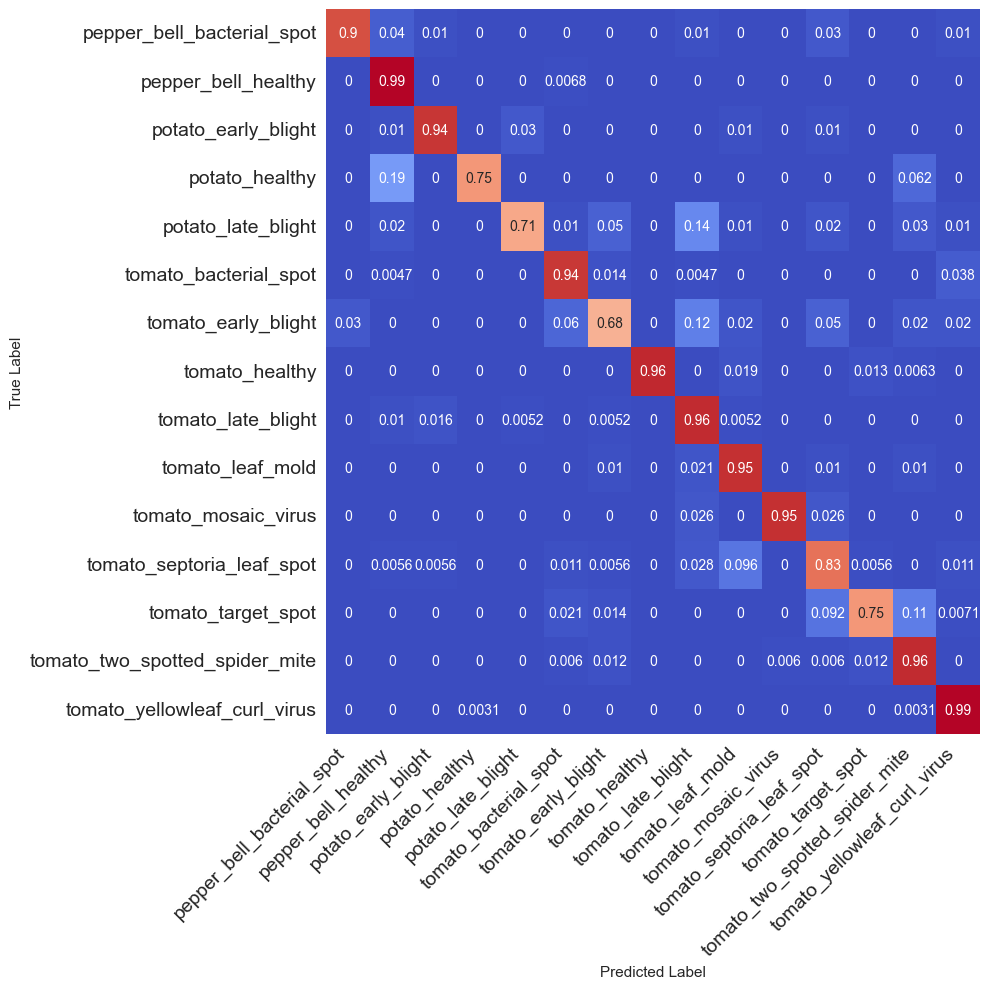

In [59]:
save_confusion_matrix([labels[i] for i in y_true], [labels[i] for i in y_pred], labels)

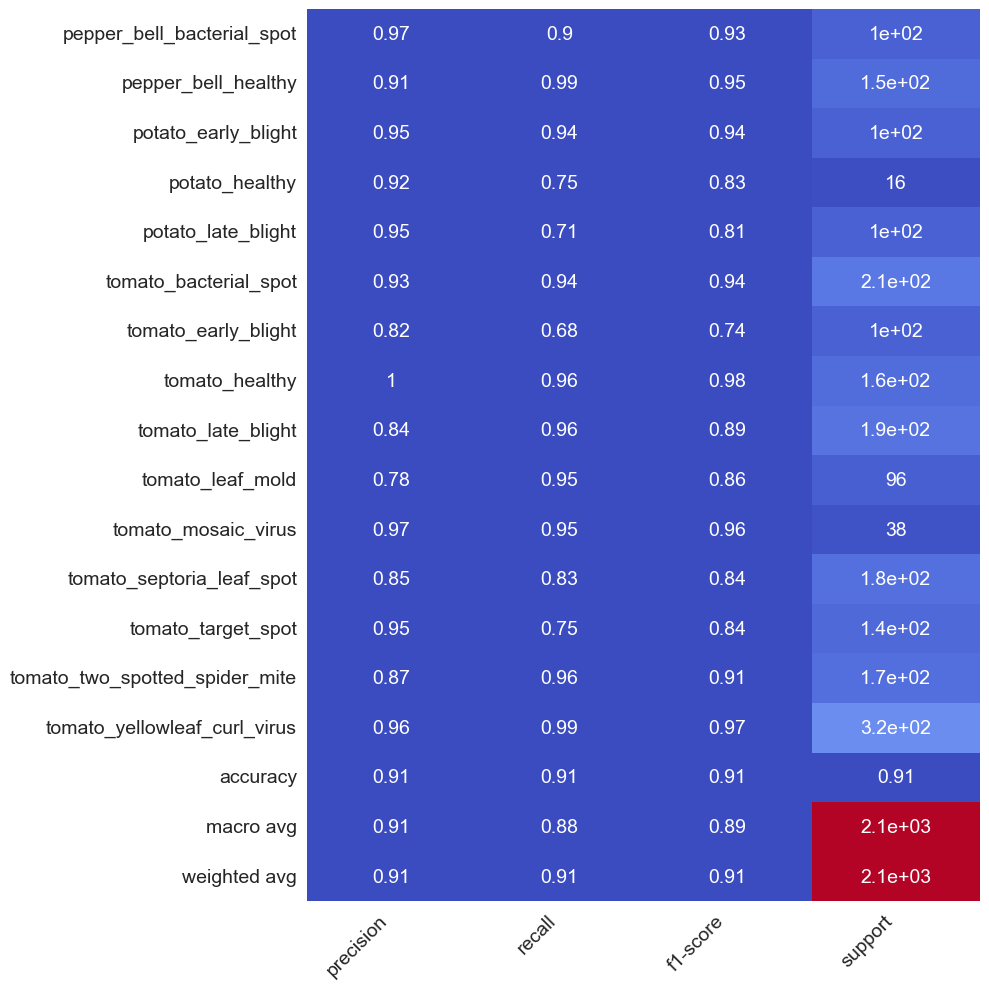

In [45]:
save_classification_report(y_true, y_pred, labels)